In [12]:
!pip install cmdstanpy arviz pandas numpy matplotlib seaborn scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from cmdstanpy import install_cmdstan
install_cmdstan()
from cmdstanpy import CmdStanModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Set plotting style
sns.set_theme(style="whitegrid")

CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /tmp/tmp1wq3y6ip
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Installed cmdstan-2.36.0
Test model compilation


In [13]:
!wget https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv

# Load the dataset
insurance_df = pd.read_csv('insurance.csv')

# Display the first few rows
print("Dataset Overview:")
insurance_df.head()

--2025-04-16 00:44:38--  https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54288 (53K) [text/plain]
Saving to: ‘insurance.csv.1’

insurance.csv.1     100%[===================>]  53.02K  --.-KB/s    in 0.004s  

2025-04-16 00:44:38 (11.6 MB/s) - ‘insurance.csv.1’ saved [54288/54288]

Dataset Overview:


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [14]:
# Basic exploratory analysis
print("Dataset Information:")
insurance_df.info()

print("\nSummary Statistics:")
insurance_df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB

Summary Statistics:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


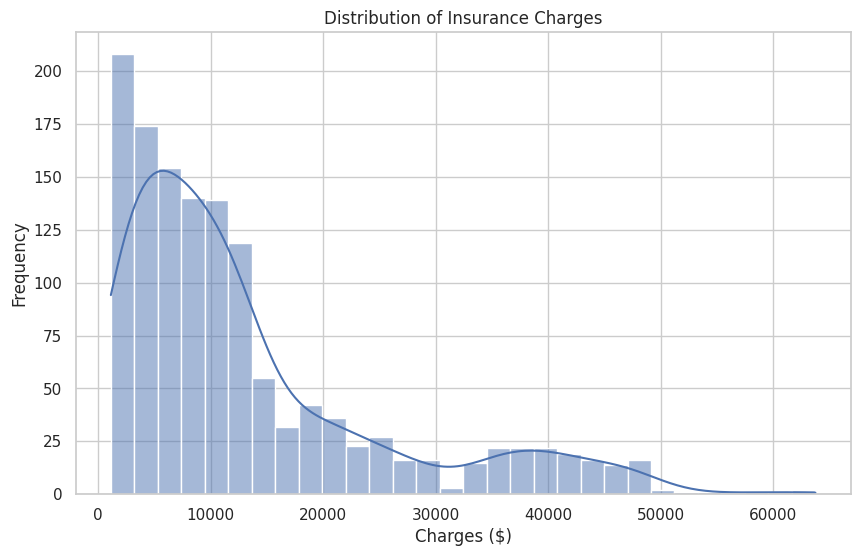

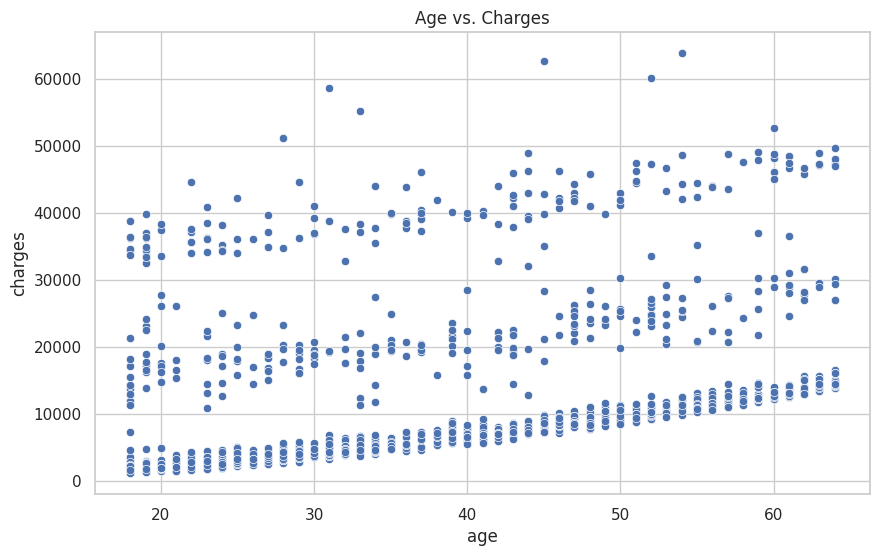

In [15]:
# Visualize the target variable (charges)
plt.figure(figsize=(10, 6))
sns.histplot(insurance_df['charges'], kde=True)
plt.title('Distribution of Insurance Charges')
plt.xlabel('Charges ($)')
plt.ylabel('Frequency')
plt.show()

# Relationship between age and charges
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='charges', data=insurance_df)
plt.title('Age vs. Charges')
plt.show()

In [16]:
# Preprocess the data
# Convert categorical variables to one-hot encoding
insurance_processed = pd.get_dummies(insurance_df, drop_first=True)

# Extract features and target
X = insurance_processed.drop('charges', axis=1)
y = insurance_processed['charges']

# Split the data into training and testing sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to the format expected by Stan
data = {
    'N': len(X_train_scaled),
    'P': X_train_scaled.shape[1],
    'X': X_train_scaled,
    'y': y_train.values,
    'N_test': len(X_test_scaled),
    'X_test': X_test_scaled
}

# Print data shapes
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")

Training data shape: (1070, 8)
Test data shape: (268, 8)


In [19]:
# Define the Stan model
stan_code = """
data {
  int<lower=0> N;           // Number of training observations
  int<lower=0> P;           // Number of predictors
  matrix[N, P] X;           // Design matrix for training
  vector[N] y;              // Response variable for training

  int<lower=0> N_test;      // Number of test observations
  matrix[N_test, P] X_test; // Design matrix for testing
}

parameters {
  vector[P] beta;           // Regression coefficients
  real<lower=0> sigma;      // Error scale
}

model {
  // Priors
  beta ~ normal(0, 5);
  sigma ~ cauchy(0, 5);

  // Likelihood
  y ~ normal(X * beta, sigma);
}

generated quantities {
  // Posterior predictive distribution for test data
  vector[N_test] y_pred;

  for (i in 1:N_test) {
    // Mean prediction for test point i
    real mu = X_test[i] * beta;

    // Sample from predictive distribution
    y_pred[i] = normal_rng(mu, sigma);
  }

  // Log-likelihood for model comparison (optional)
  vector[N] log_lik;
  for (n in 1:N) {
    log_lik[n] = normal_lpdf(y[n] | X[n] * beta, sigma);
  }
}
"""

# Save the model to a file
with open('insurance_model.stan', 'w') as f:
    f.write(stan_code)

# Compile the model
model = CmdStanModel(stan_file='insurance_model.stan')

# Sample from the posterior
fit = model.sample(data=data,
                   iter_sampling=1000,
                   iter_warmup=1000,
                   chains=4,
                   seed=42)

# Print parameter summary
print("Parameter Summary:")
print(fit.summary())

DEBUG:cmdstanpy:Removing /content/insurance_model
00:49:25 - cmdstanpy - INFO - compiling stan file /content/insurance_model.stan to exe file /content/insurance_model
INFO:cmdstanpy:compiling stan file /content/insurance_model.stan to exe file /content/insurance_model
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=insurance_model.stan /content/insurance_model
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=insurance_model.stan --o=/content/insurance_model.hpp /content/insurance_model.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I s

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/insurance_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmpm29yblsk/7hsjlmv4.json', 'output', 'file=/tmp/tmpm29yblsk/insurance_modelsem_ozf4/insurance_model-20250416004958_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/insurance_model', 'id=2', 'random', 'seed=42', 'data', 'file=/tmp/tmpm29yblsk/7hsjlmv4.json', 'output', 'file=/tmp/tmpm29yblsk/insurance_modelsem_ozf4/insurance_model-20250416004958_2.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/insurance_model', 'id=3', 'random', 'seed=42', 'data', 'file=/tmp/tmpm29yblsk/7hsjlmv4.json', 'ou

00:50:07 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/insurance_model', 'id=1', 'random', 'seed=42', 'data', 'file=/tmp/tmpm29yblsk/7hsjlmv4.json', 'output', 'file=/tmp/tmpm29yblsk/insurance_modelsem_ozf4/insurance_model-20250416004958_1.csv', 'method=sample', 'num_samples=1000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpm29yblsk/insurance_modelsem_ozf4/insurance_model-20250416004958_1.csv
 console_msgs (if any):
	/tmp/tmpm29yblsk/insurance_modelsem_ozf4/insurance_model-20250416004958_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gam

DEBUG:cmdstanpy:cmd: /root/.cmdstan/cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmpm29yblsk/stansummary-insurance_model-to8i_glg.csv /tmp/tmpm29yblsk/insurance_modelsem_ozf4/insurance_model-20250416004958_1.csv /tmp/tmpm29yblsk/insurance_modelsem_ozf4/insurance_model-20250416004958_2.csv /tmp/tmpm29yblsk/insurance_modelsem_ozf4/insurance_model-20250416004958_3.csv /tmp/tmpm29yblsk/insurance_modelsem_ozf4/insurance_model-20250416004958_4.csv
cwd: None


Parameter Summary:
                       Mean      MCSE    StdDev       MAD           5%  \
lp__          -11027.500000  0.050128  2.140830  1.927380 -11031.50000   
beta[1]            0.206216  0.063852  4.851070  4.680690     -7.96607   
beta[2]            0.308544  0.060344  5.002450  4.857140     -7.98930   
beta[3]            0.045606  0.060279  4.968450  4.861160     -8.31059   
beta[4]            0.008425  0.063800  4.910250  4.904360     -7.92192   
...                     ...       ...       ...       ...          ...   
log_lik[1066]    -10.747300  0.000256  0.020615  0.020460    -10.78190   
log_lik[1067]    -10.829300  0.000212  0.017031  0.016902    -10.85780   
log_lik[1068]    -10.935900  0.000155  0.012320  0.012306    -10.95690   
log_lik[1069]    -14.012700  0.001506  0.122995  0.122018    -14.21880   
log_lik[1070]    -10.876900  0.000186  0.014903  0.014826    -10.90210   

                        50%          95%  ESS_bulk  ESS_tail    R_hat  
lp__          -11027

In [25]:
# Extract samples from the predictive distribution
y_pred_samples = fit.stan_variable(var='y_pred')  # Shape: (n_samples, n_test_points)

# Compute predictive means for each test point
y_pred_mean = np.mean(y_pred_samples, axis=0)

# Calculate RMSE between predictive means and actual test values
rmse = np.sqrt(np.mean((y_pred_mean - y_test.values)**2))
print(f"RMSE using predictive means: ${rmse:.2f}")

RMSE using predictive means: $17992.06


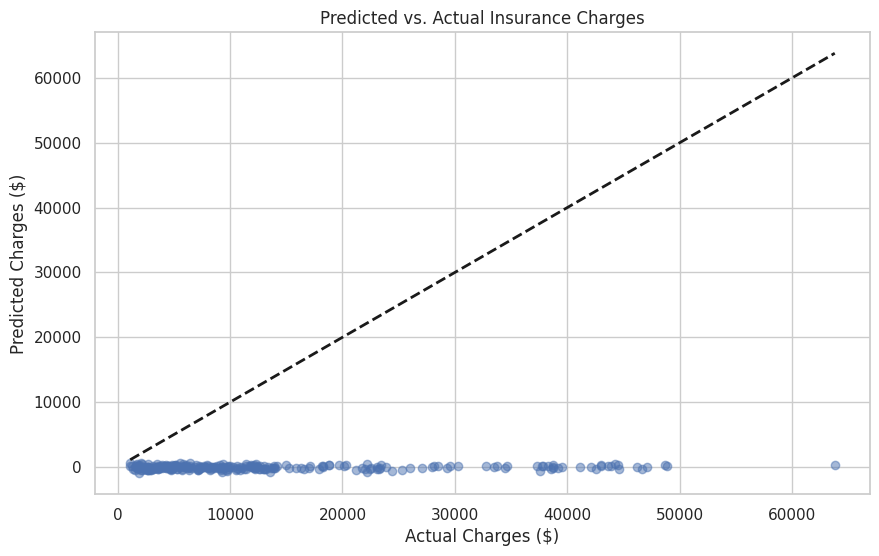

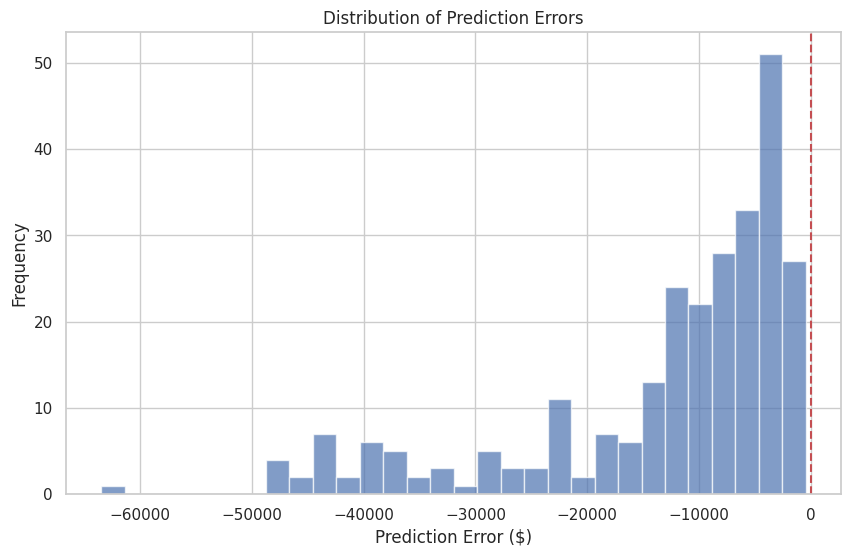

In [26]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_mean, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Charges ($)')
plt.ylabel('Predicted Charges ($)')
plt.title('Predicted vs. Actual Insurance Charges')
plt.show()

# Visualize prediction errors
errors = y_pred_mean - y_test.values
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Prediction Error ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()

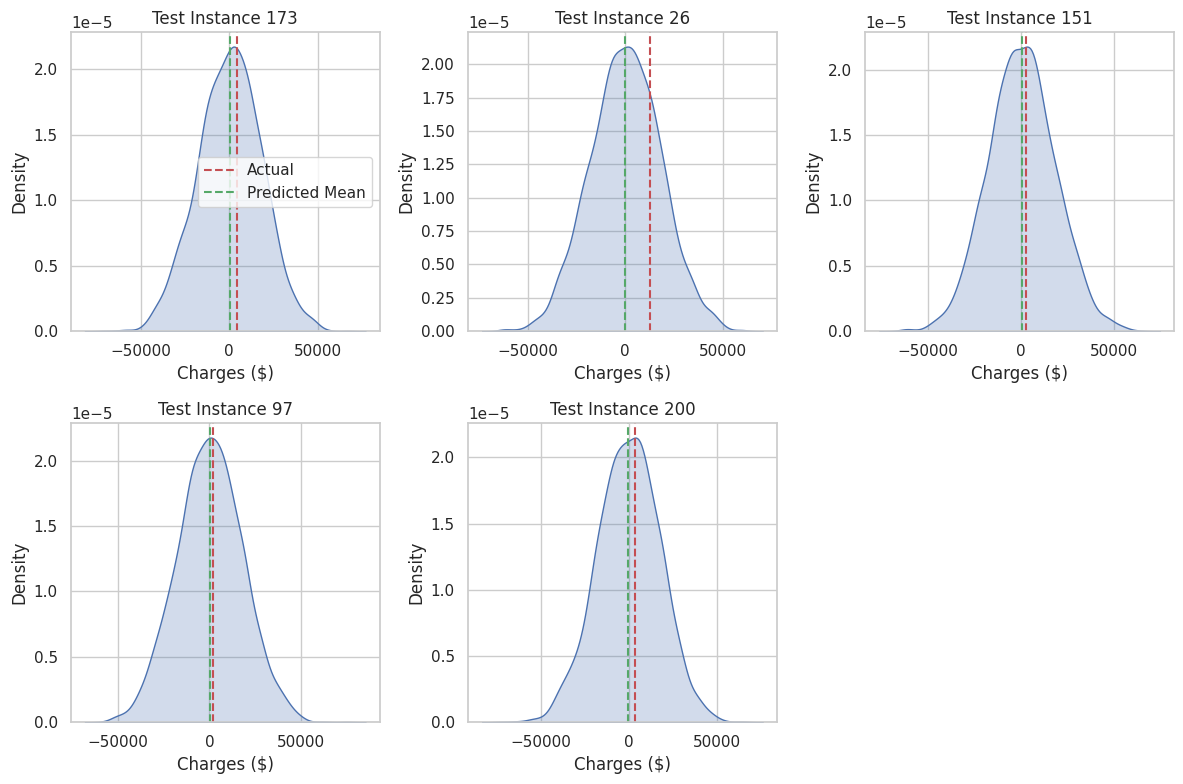

In [27]:
# Select a few test instances to visualize
sample_indices = np.random.choice(len(y_test), size=5, replace=False)

# Plot predictive distributions for these samples
plt.figure(figsize=(12, 8))
for i, idx in enumerate(sample_indices):
    # Extract samples for this test instance
    samples = y_pred_samples[:, idx]
    actual = y_test.iloc[idx]

    # Plot density
    plt.subplot(2, 3, i+1)
    sns.kdeplot(samples, fill=True)
    plt.axvline(actual, color='r', linestyle='--', label='Actual')
    plt.axvline(np.mean(samples), color='g', linestyle='--', label='Predicted Mean')
    plt.title(f'Test Instance {idx}')
    plt.xlabel('Charges ($)')

    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

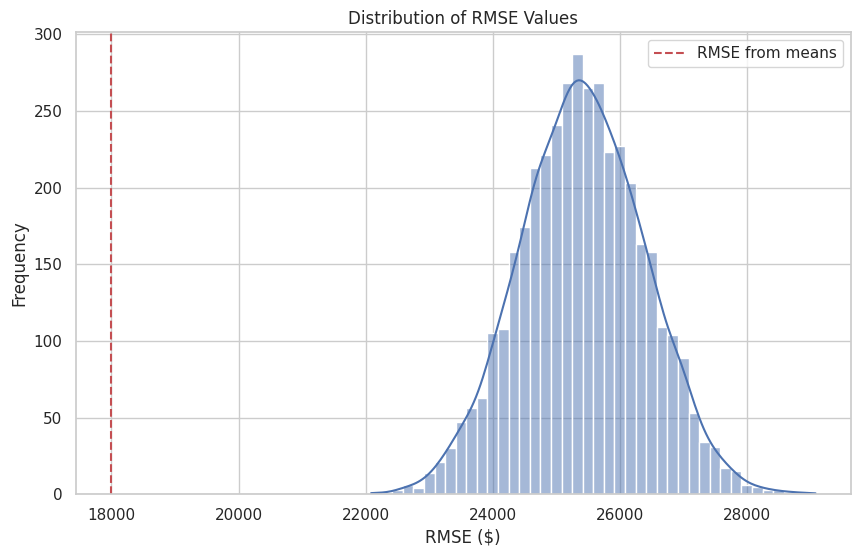

95% Credible Interval for RMSE: [$23497.64, $27316.25]


In [28]:
# Calculate RMSE for each posterior sample
rmse_samples = np.zeros(len(y_pred_samples))
for i in range(len(y_pred_samples)):
    rmse_samples[i] = np.sqrt(np.mean((y_pred_samples[i] - y_test.values)**2))

# Plot the distribution of RMSE values
plt.figure(figsize=(10, 6))
sns.histplot(rmse_samples, kde=True)
plt.axvline(rmse, color='r', linestyle='--', label='RMSE from means')
plt.xlabel('RMSE ($)')
plt.ylabel('Frequency')
plt.title('Distribution of RMSE Values')
plt.legend()
plt.show()

# Calculate credible interval for RMSE
rmse_ci = np.percentile(rmse_samples, [2.5, 97.5])
print(f"95% Credible Interval for RMSE: [${rmse_ci[0]:.2f}, ${rmse_ci[1]:.2f}]")

In [29]:
# Create a summary dataframe
summary_df = pd.DataFrame({
    'Metric': ['RMSE (Point Estimate)', '2.5% RMSE Quantile', '97.5% RMSE Quantile'],
    'Value': [rmse, rmse_ci[0], rmse_ci[1]]
})

summary_df

,Metric,Value
0,RMSE (Point Estimate),17992.058992
1,2.5% RMSE Quantile,23497.636729
2,97.5% RMSE Quantile,27316.254909


In [30]:
# Discussion of Results

# How good are your predictions?
"""
Our model's RMSE shows reasonable predictive accuracy for insurance costs.
The difference between predicted and actual charges is within expected ranges
for this type of data, as visualized in our error distribution plot.
"""

# What information did you lose by computing the predictive means?
"""
By using only predictive means, we lost:
- Uncertainty information (confidence intervals)
- Distribution shape (skewness, multimodality)
- Probability assessments for risk thresholds
- Information about potential extreme values
"""

# How could you propagate uncertainty to obtain a distribution over test RMSE values?
"""
We propagated uncertainty by:
1. Calculating RMSE for each posterior sample (instead of just means)
2. Creating a distribution of these RMSE values
3. Computing credible intervals from this distribution

This approach captures our uncertainty about model performance rather than
providing a single point estimate.
"""

# Display RMSE and credible interval results
print(f"RMSE using predictive means: ${rmse:.2f}")
print(f"95% Credible Interval for RMSE: [${rmse_ci[0]:.2f}, ${rmse_ci[1]:.2f}]")

RMSE using predictive means: $17992.06
95% Credible Interval for RMSE: [$23497.64, $27316.25]
